
# Προπαρασκευή 3ου Εργαστηρίου
*   Αχλάτης Στέφανος-Σταμάτης (03116149)
*   Στόικου Θεοδότη (03117085)



#Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -r /content/drive/MyDrive/lab3/requirements.txt

     |████████████████████████████████| 14.5MB 242kB/s 
     |████████████████████████████████| 71kB 8.8MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 22.2MB 1.3MB/s 
     |████████████████████████████████| 1.4MB 46.7MB/s 
  Created wheel for nltk: filename=nltk-3.5-cp36-none-any.whl size=1434675 sha256=eac881e974371db18ada2c6d9f0ca9d84ed0ffbcf5ba97b0d0dc25c0eab25df6
  Stored in directory: /root/.cache/pip/wheels/ae/8c/3f/b1fe0ba04555b08b57ab52ab7f86023639a526d8bc8d384306
Successfully built nltk
ERROR: torchvision 0.8.1+cu101 has requirement torch==1.7.0, but you'll have torch 1.7.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalle

In [ ]:
# !unzip /content/drive/MyDrive/lab3/embeddings/glove.6B.zip

# !mv glove.* /content/drive/MyDrive/lab3/embeddings -f

#Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import random
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.decomposition import PCA
from google.colab import files
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
import sklearn.model_selection
from sklearn.ensemble import VotingClassifier,BaggingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.stats import multivariate_normal
from sklearn import preprocessing
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import DataLoader
from config import EMB_PATH
from dataloading import SentenceDataset
from models import BaselineDNN
from training import train_dataset, eval_dataset
from utils.load_datasets import load_MR, load_Semeval2017A
from utils.load_embeddings import load_word_vectors
from sklearn.metrics import f1_score, accuracy_score, recall_score
import seaborn as sns
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# 1. Προεπεξεργασία Δεδομένων


In [ ]:
import os
os.chdir("/content/drive/MyDrive/lab3/")

Θα χρησιμοποιήσουμε τα εργαλεία που παρέχει το PyTorch (κλάσεις Dataset και Dataloader κλπ.). Η κλάση torch.utils.data.Dataset μετατρέπει κάθε παράδειγμα στην μορφή που
απαιτείται για την εκπαίδευση του νευρωνικού δικτύου και η κλάση torch.utils.data.Dataloader
χρησιμοποιεί ένα αντικείμενο της κλάσης Dataset για να μετατρέψει τα παραδείγματα του σε torch
Tensors και να τα οργανώσει σε mini-batces.

In [ ]:
########################################################
# Configuration
########################################################


# Download the embeddings of your choice
# for example http://nlp.stanford.edu/data/glove.6B.zip

# 1 - point to the pretrained embeddings file (must be in /embeddings folder)
EMBEDDINGS = os.path.join(EMB_PATH, "glove.6B.50d.txt")

# 2 - set the correct dimensionality of the embeddings
EMB_DIM = 50

EMB_TRAINABLE = False
BATCH_SIZE = 128
EPOCHS = 50
DATASET = "MR"  # options: "MR", "Semeval2017A"

# if your computer has a CUDA compatible gpu use it, otherwise use the cpu
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
########################################################
# Define PyTorch datasets and dataloaders
########################################################

# load word embeddings
print("loading word embeddings...")
word2idx, idx2word, embeddings = load_word_vectors(EMBEDDINGS, EMB_DIM)

# load the raw data
X_train1, y_train1, X_test1, y_test1 = load_Semeval2017A()
X_train2, y_train2, X_test2, y_test2 = load_MR()


loading word embeddings...
Loaded word embeddings from cache.


**Κωδικοποίηση Επισημειώσεων (Labels):**

Αρχικά οι επισημειώσεις των παραδειγμάτων εκπαίδευσης έχουν την μορφή κειμένου (positive,
neutral, negative...). Τις κωδικοποιούμε, ώστε κάθε κλάση να αντιστοιχεί σε έναν
συγκεκριμένο αριθμό.

In [ ]:
# convert data labels from strings to integers
le1 = preprocessing.LabelEncoder()
le1.fit(y_train1)
# print(le.classes_)

y_train1 = le1.transform(y_train1)  # EX1
y_test1 = le1.transform(y_test1)  # EX1
n_classes1 = le1.classes_.size  # EX1 - LabelEncoder.classes_.size

# convert data labels from strings to integers
le2 = preprocessing.LabelEncoder()
le2.fit(y_train2)
# print(le.classes_)

y_train2 = le2.transform(y_train2)  # EX1
y_test2 = le2.transform(y_test2)  # EX1
n_classes2 = le2.classes_.size  # EX1 - LabelEncoder.classes_.size


Τυπώνουμε παρακάτω τα πρώτα 10 labels
από τα δεδομένα εκπαίδευσης και τις αντιστοιχίες τους σε αριθμούς:

In [ ]:
print("Semeval Dataset")
print("Unencoded labels from the training set: ")
print(le1.inverse_transform(y_train1[0:10]))
print("Encoded labels from the training set: ")
print(y_train1[0:10])

print()
print("MR Dataset")
print("Unencoded labels from the training set: ")
print(le2.inverse_transform(y_train2[0:10]))
print("Encoded labels from the training set: ")
print(y_train2[0:10])

Semeval Dataset
Unencoded labels from the training set: 
['neutral' 'neutral' 'negative' 'neutral' 'neutral' 'positive' 'positive'
 'neutral' 'positive' 'positive']
Encoded labels from the training set: 
[1 1 0 1 1 2 2 1 2 2]

MR Dataset
Unencoded labels from the training set: 
['positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive' 'positive' 'positive' 'positive']
Encoded labels from the training set: 
[1 1 1 1 1 1 1 1 1 1]


**Λεκτική Ανάλυση (Tokenization):**

Μετατρέπουμε το κείμενο από μία ακολουθία χαρακτήρων, σε μία ακολουθία
από λεκτικές μονάδες ή όρους (tokens ή terms), όπως λέξεις, σημεία στίξης, αριθμούς κλπ. Τυπώνουμε παρακάτω τα πρώτα 10 παραδείγματα από τα δεδομένα εκπαίδευσης:

In [ ]:
print("Semeval Dataset")

# Define our PyTorch-based Dataset
train_set1 = SentenceDataset(X_train1, y_train1, word2idx)
test_set1 = SentenceDataset(X_test1, y_test1, word2idx)

# print(train_set.__getitem__(0))
for i in range(10):
  print(train_set1.data[i])

print()
print("MR Dataset")
# Define our PyTorch-based Dataset
train_set2 = SentenceDataset(X_train2, y_train2, word2idx)
test_set2 = SentenceDataset(X_test2, y_test2, word2idx)

# print(train_set.__getitem__(0))
for i in range(10):
  print(train_set2.data[i])

Semeval Dataset
['Won', 'the', 'match', '#getin', '.', 'Plus', '\\', 'u002c', 'tomorrow', 'is', 'a', 'very', 'busy', 'day', '\\', 'u002c', 'with', 'Awareness', 'Day', '\\', 'u2019s', 'and', 'debates', '.', 'Gulp', '.', 'Debates', '...']
['Some', 'areas', 'of', 'New', 'England', 'could', 'see', 'the', 'first', 'flakes', 'of', 'the', 'season', 'Tuesday', '.']
['@francesco_con40', '2nd', 'worst', 'QB', '.', 'DEFINITELY', 'Tony', 'Romo', '.', 'The', 'man', 'who', 'likes', 'to', 'share', 'the', 'ball', 'with', 'everyone', '.', 'Including', 'the', 'other', 'team', '.']
['#Thailand', 'Washington', '-', 'US', 'President', 'Barack', 'Obama', 'vowed', 'Wednesday', 'as', 'he', 'visited', 'storm-ravaged', 'New', 'Jersey', 'shore', 'to', '...', 'http://t.co/Xzl4LFhs']
['Did', 'y', '\\', 'u2019all', 'hear', 'what', 'Tony', 'Romo', 'dressed', 'up', 'as', 'for', 'Halloween', '?', 'A', 'Giants', 'quaterback', '!', 'Cause', 'that', '\\', 'u2019s', 'all', 'he', 'could', 'throw', 'to', 'sunday', 'night', 

**Κωδικοποίηση Παραδειγμάτων (Λέξεων):**

Χαρτογραφούμε κάθε όρο (token - term) σε ένα αριθμό, ώστε να μπορεί το embedding layer να τον αντιστοιχίσει στη σωστή διανυσματική αναπαράσταση (word embedding).

Φροντίζουμε όλα τα παραδείγματα να έχουν το ίδιο μήκος, ώστε να μπορούν να
εκτελεστούν πράξεις γραμμικής άλγεβρας, όπως πολλαπλασιασμός πινάκων. Επιλέγουμε λοιπόν ένα μέγιστο μήκος προτάσεων και συμπληρώνουμε με μηδενικά
στοιχεία τις προτάσεις μικρότερου μήκους (zero-padding) ή να αφαιρούμε λέξεις που ξεπερνούν
το επιλεγμένο μήκος.

Τυπώνουμε την κατανομή με τα μήκη των προτάσεων στο
training set για να διαλέξουμε ένα μήκος το οποίο να καλύπτει την πλειοψηφία, αγνοώντας
τους outliers. Επιλέξαμε το 50, που φαίνεται ικανοποιητική επιλογή τόσο για το MR όσο και για το Semeval2017A dataset.

Semeval


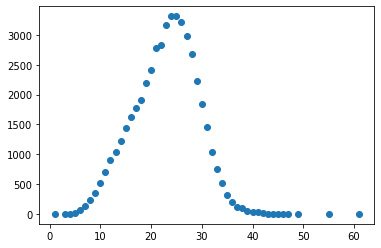


MR Dataset


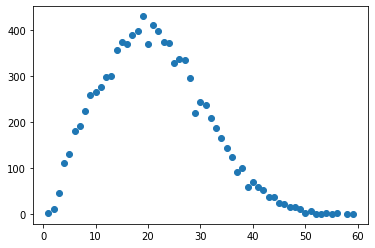

In [ ]:
print("Semeval")
X = [len(i) for i in X_train1]
x,y = np.unique(X,return_counts=True)
plt.scatter(x,y)
plt.show()

print()
print("MR Dataset")

X = [len(i) for i in X_train2]
x,y = np.unique(X,return_counts=True)
plt.scatter(x,y)
plt.show()


Αφού έχουμε υλοποιήσει τη μέθοδο getitem της κλάσης SentenceDataset, τυπώνουμε παρακάτω 5 παραδείγματα στην αρχική τους μορφή και όπως τα επιστρέφει η κλάση SentenceDataset:


In [ ]:
def printExamples(X_train,train_set):
  for i in [20,45,23,1,89]:
    print("Original sentence is: ")
    print(X_train[i],'\n')
    
    enc = train_set[i]
    print("Encoded sentence is: ")
    print(enc[0],'\n')
    print('Label is: ',enc[1])
    print('Length is: ',enc[2],'\n')
    print('-----------------------------------')
  return

In [ ]:
printExamples(X_train1,train_set1)

Original sentence is: 
['Gary', 'Ablett', 'wins', 'the', 'AFLPA', 'MVP', 'for', 'the', '4th', 'time', 'in', 'his', 'career', '.', 'He', 'should', 'have', 'started', 'his', 'speech', 'with', '-', '"', 'Yeah', '\\', 'u002c', 'I', '\\', 'u2019d', '...', 'http://t.co/K31dSryH'] 

Encoded sentence is: 
[4.00001e+05 4.00001e+05 1.89100e+03 1.00000e+00 4.00001e+05 4.00001e+05
 1.10000e+01 1.00000e+00 4.61800e+03 8.00000e+01 7.00000e+00 2.70000e+01
 4.33000e+02 3.00000e+00 4.00001e+05 1.90000e+02 3.40000e+01 5.52000e+02
 2.70000e+01 1.29400e+03 1.80000e+01 1.20000e+01 9.00000e+00 4.00001e+05
 7.95800e+03 4.00001e+05 4.00001e+05 7.95800e+03 3.40841e+05 4.35000e+02
 4.00001e+05 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00] 

Label is:  2
Length is:  31 

-----------------------------------
Original sentence is: 


In [ ]:
printExamples(X_train2,train_set2)

Original sentence is: 
['a', 'thoughtful', ',', 'provocative', ',', 'insistently', 'humanizing', 'film', '.'] 

Encoded sentence is: 
[8.0000e+00 1.6455e+04 2.0000e+00 1.1008e+04 2.0000e+00 7.0583e+04
 9.3310e+04 3.2000e+02 3.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00] 

Label is:  1
Length is:  9 

-----------------------------------
Original sentence is: 
['karmen', 'moves', 'like', 'rhythm', 'itself', ',', 'her', 'lips', 'chanting', 'to', 'the', 'beat', ',', 'her', 'long', ',', 'braided', 'hair', 'doing', 'little', 'to', 'wipe', 'away', 'the', 'jeweled', 'beads', 'of

#2,3. Μοντέλο - Διαδικασία Εκπαίδευσης

Σχεδιάσαμε ένα νευρωνικό δίκτυο, το οποίο 1) θα δημιουργεί μία
συνεχή διανυσματική αναπαράσταση για κάθε όρο σε μία πρόταση με την χρήση ενός Embedding
layer, 2) θα δημιουργεί μία διανυσματική αναπαράσταση για όλο το κείμενο ενός παραδείγματος, 3)
3
θα κατηγοριοποιεί το κείμενο βάσει της αναπαράστασης του στην σωστή κλάση.

Στη συνέχεια, υλοποιήσαμε την διαδικασία εκπαίδευσης του δικτύου, δηλαδή οργανώσαμε τα παραδείγματα σε mini-batches και να εκτελέσουμε stochastic gradient descent για
να ενημερώνουμε τα βάρη του δικτύου.

**Φόρτωση Παραδειγμάτων (DataLoaders)**

In [ ]:
# EX4 - Define our PyTorch-based DataLoader
train_loader1 = DataLoader(dataset=train_set1, batch_size=BATCH_SIZE, shuffle=True)   # EX7
test_loader1 = DataLoader(dataset=test_set1, batch_size=BATCH_SIZE, shuffle=False)  # EX7

train_loader2 = DataLoader(dataset=train_set2, batch_size=BATCH_SIZE, shuffle=True)   # EX7
test_loader2 = DataLoader(dataset=test_set2, batch_size=BATCH_SIZE, shuffle=False)  # EX7


**Βελτιστοποίηση:**

Για την βελτιστοποίηση του μοντέλου ορίσαμε τα εξής:
1. Κριτήριο. Αν το πρόβλημα κατηγοριοποίησης έχει 2 κλάσεις τότε χρησιμοποιούμε το
BCEWithLogitsLoss, ενώ αν έχει περισσότερες το CrossEntropyLoss.
2. Παράμετροι (επιλογή παραμέτρων οι οποίες θα βελτιστοποιηθούν)
3. Optimizer. Επιλέξαμε τον αλγόριθμο βελτιστοποίησης Adam.

In [ ]:
#############################################################################
# Model Definition (Model, Loss Function, Optimizer)
#############################################################################
model1 = BaselineDNN(output_size= n_classes1,  # EX8
                    embeddings=embeddings,
                    trainable_emb=EMB_TRAINABLE)

# move the mode weight to cpu or gpu
model1.to(DEVICE)

# We optimize ONLY those parameters that are trainable (p.requires_grad==True)
criterion1 = torch.nn.CrossEntropyLoss() # EX8

parameters1 = model1.parameters()

optimizer1 = torch.optim.Adam(parameters1)  # EX8


model2 = BaselineDNN(output_size= n_classes2,  # EX8
                    embeddings=embeddings,
                    trainable_emb=EMB_TRAINABLE)

# move the mode weight to cpu or gpu
model2.to(DEVICE)

# We optimize ONLY those parameters that are trainable (p.requires_grad==True)
criterion2 = torch.nn.BCEWithLogitsLoss()

parameters2 = model2.parameters()
optimizer2 = torch.optim.Adam(parameters2)  # EX8


**Αξιολόγηση:**

Επιλέξαμε να εκπαιδεύσουμε το μοντέλο μας σε 50 εποχές (προεπιλεγμένη τιμή).

Για κάθε ένα από τα 2 datasets αναφέρουμε τις επιδόσεις του μοντέλου στις μετρικές: accuracy, F1 score (macro average), recall (macro average. Επίσης, δημιουργήσαμε γραφικές παραστάσεις, στις οποίες θα φαίνονται οι καμπύλες εκπαίδευσης του μοντέλου (training και test loss) ανά εποχή.

Για την αξιολόγηση του μοντέλου μας, χρησιμοποιήσαμε τη βιβλιοθήκη sklearn.metrics.

In [ ]:
#############################################################################
# Training Pipeline
#############################################################################
def training_pipeline(train_loader,test_loader,model,criterion,optimizer,DATASET):
  total_train_losses = []
  total_test_losses = []
  for epoch in range(1, EPOCHS + 1):
      # train the model for one epoch
      train_dataset(epoch, train_loader, model, criterion, optimizer,DATASET)

      # evaluate the performance of the model, on both data sets
      train_loss, (y_train_gold, y_train_pred) = eval_dataset(train_loader,
                                                            model,
                                                            criterion, DATASET)

      test_loss, (y_test_gold, y_test_pred) = eval_dataset(test_loader,
                                                         model,
                                                         criterion, DATASET)
      total_train_losses.append(train_loss)
      total_test_losses.append(test_loss)

      # Convert predictions and golds to a plottable format

      y_train_true = y_train_gold
      y_test_true = y_test_gold
      # y_train_pred = y_train_pred
      # y_test_pred = y_test_pred

  # Print statistics
  print('Train loss: ',train_loss)
  print('Test loss: ',test_loss)
  print("Accuracy (train): " , accuracy_score(y_train_true, y_train_pred))
  print("Accuracy (test):" , accuracy_score(y_test_true, y_test_pred))
  print("F1 score (train): ", f1_score(y_train_true, y_train_pred, average='macro'))
  print("F1 score (test): ", f1_score(y_test_true, y_test_pred, average='macro'))
  print("Recall (train):", recall_score(y_train_true, y_train_pred, average='macro'))
  print("Recall (test):", recall_score(y_test_true, y_test_pred, average='macro'))

  return total_train_losses, total_test_losses

In [ ]:
def printRes(total_train_losses,total_test_losses):
  fig = plt.figure()
  plt.plot(total_train_losses,  label="train data")
  plt.plot(total_test_losses,  label="test data")
  fig.suptitle('Loss - epochs for both train and test set', fontsize=20)
  plt.xlabel('epochs', fontsize=18)
  plt.ylabel('cummulative running loss', fontsize=16)
  plt.legend()
  plt.show()

In [ ]:
total_train_losses1, total_test_losses1 = training_pipeline(train_loader1,test_loader1,model1,criterion1,optimizer1,"Semeval2017A")

 [========================================] ...Epoch 1, Loss: 0.8856
 [========================================] ...Epoch 2, Loss: 0.8366
 [========================================] ...Epoch 3, Loss: 0.7859
 [========================================] ...Epoch 4, Loss: 0.9909
 [========================================] ...Epoch 5, Loss: 1.0307
 [========================================] ...Epoch 6, Loss: 0.7805
 [========================================] ...Epoch 7, Loss: 0.9593
 [========================================] ...Epoch 8, Loss: 0.8088
 [========================================] ...Epoch 9, Loss: 0.8375
 [========================================] ...Epoch 10, Loss: 0.7860
 [========================================] ...Epoch 11, Loss: 0.8318
 [========================================] ...Epoch 12, Loss: 0.7855
 [========================================] ...Epoch 13, Loss: 0.9867
 [========================================] ...Epoch 14, Loss: 0.8562
 [===========================

In [ ]:
total_train_losses2, total_test_losses2 = training_pipeline(train_loader2,test_loader2,model2,criterion2,optimizer2,"MR")

 [========================================] ...Epoch 1, Loss: 0.6515
 [========================================] ...Epoch 2, Loss: 0.6200
 [========================================] ...Epoch 3, Loss: 0.5486
 [========================================] ...Epoch 4, Loss: 0.4853
 [========================================] ...Epoch 5, Loss: 0.7926
 [========================================] ...Epoch 6, Loss: 0.4304
 [========================================] ...Epoch 7, Loss: 0.7142
 [========================================] ...Epoch 8, Loss: 0.5414
 [========================================] ...Epoch 9, Loss: 0.5531
 [========================================] ...Epoch 10, Loss: 0.7681
 [========================================] ...Epoch 11, Loss: 0.5714
 [========================================] ...Epoch 12, Loss: 0.7209
 [========================================] ...Epoch 13, Loss: 0.5068
 [========================================] ...Epoch 14, Loss: 0.6460
 [===========================

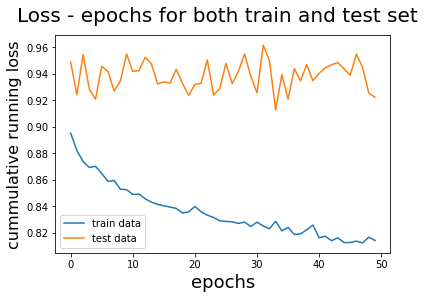

In [ ]:
printRes(total_train_losses1, total_test_losses1)

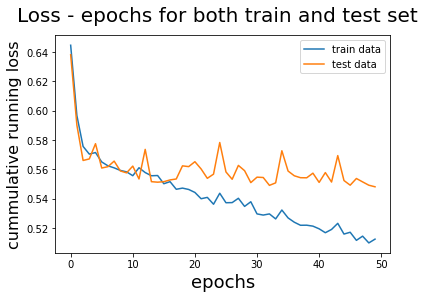

In [ ]:
printRes(total_train_losses2, total_test_losses2)